# Data Preparation

# Loading Data

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint
data_file_path = ""
csv_file_name = "Austin Bicycle Crashes 2010-2017.csv"
dataset = pd.read_csv(data_file_path+csv_file_name)
dataset.head()

,Crash ID,$1000 Damage to Any One Person's Property,Active School Zone Flag,Adjusted Average Daily Traffic Amount,Agency,At Intersection Flag,Average Daily Traffic Amount,Average Daily Traffic Year,Case ID,City,...,Roadway Relation,Roadway Type,Speed Limit,Street Name,Street Number,Surface Condition,Traffic Control Type,Weather Condition,Person Helmet,Person Type
0,11243623,No,No,15262,Austin Police Department,False,15262,2014,100010723,Austin,...,On Roadway,"4 Or More Lanes, Undivided",45,FM0969,4716,Dry,Marked Lanes,Clear,"Worn, Damaged",Pedalcyclist
1,12112069,No,No,No Data,Austin Police Department,False,No Data,No Data,100010834,Austin,...,On Roadway,No Data,35,E RIVERSIDE DR,200,Dry,Center Stripe/Divider,Clear,Not Worn,Pedalcyclist
2,12112069,No,No,No Data,Austin Police Department,False,No Data,No Data,100010834,Austin,...,On Roadway,No Data,35,E RIVERSIDE DR,200,Dry,Center Stripe/Divider,Clear,Not Worn,Pedalcyclist
3,12112069,No,No,No Data,Austin Police Department,False,No Data,No Data,100010834,Austin,...,On Roadway,No Data,35,E RIVERSIDE DR,200,Dry,Center Stripe/Divider,Clear,Not Worn,Pedalcyclist
4,11376123,No,No,22775,Austin Police Department,False,22775,2014,100042009,Austin,...,On Roadway,"4 Or More Lanes, Undivided",45,SL0111,1487,Dry,None,Clear,Not Worn,Pedalcyclist


<AxesSubplot:>

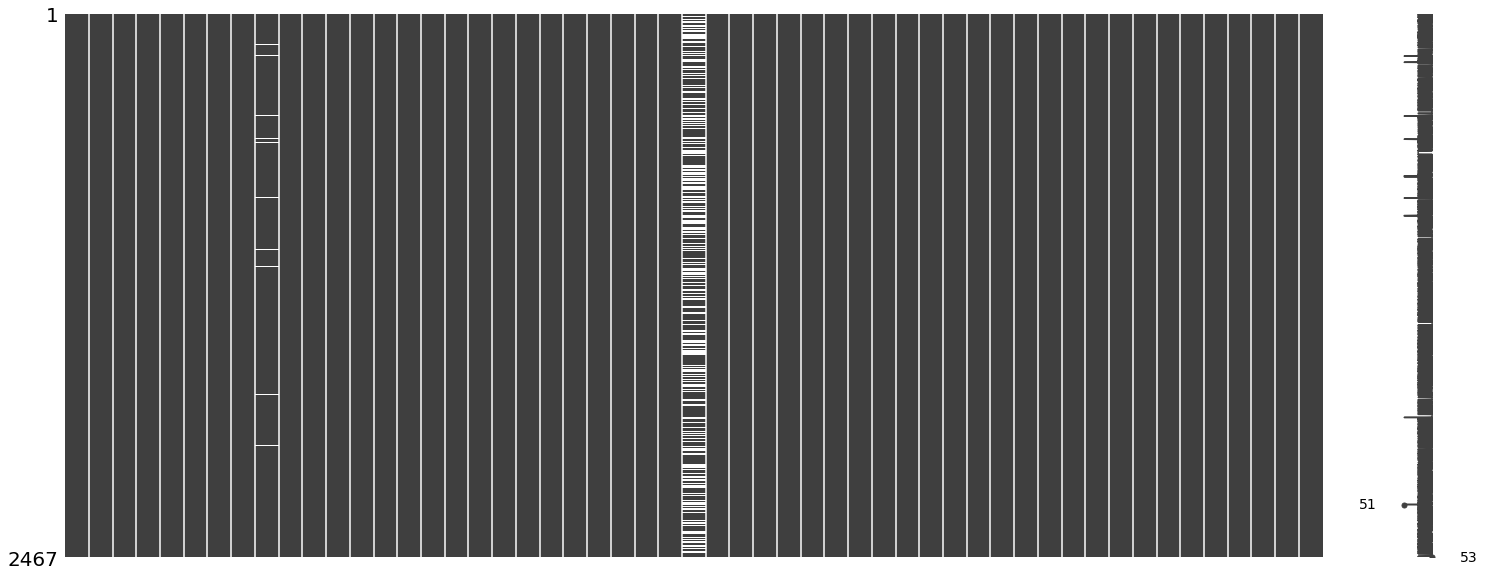

In [3]:
import missingno as msno
msno.matrix(dataset)

In [27]:
dataset.count().max()

2467

In [28]:
dataset.dtypes

Crash ID                                      int64
$1000 Damage to Any One Person's Property    object
Active School Zone Flag                      object
Adjusted Average Daily Traffic Amount        object
Agency                                       object
At Intersection Flag                           bool
Average Daily Traffic Amount                 object
Average Daily Traffic Year                   object
Case ID                                      object
City                                         object
Construction Zone Flag                       object
Construction Zone Workers Present Flag       object
County                                       object
Crash Death Count                             int64
Crash Incapacitating Injury Count             int64
Crash Non-incapacitating Injury Count         int64
Crash Not Injured Count                       int64
Crash Possible Injury Count                   int64
Crash Severity                               object
Crash Time  

# Store and Restore the Fields Grouping

In [29]:
# store the fields in another csv file
def save_df_csv(csv_str, file_name, path=""):
	f = open(path+file_name, "w")
	f.write(csv_str)
	f.close()
li = list(dataset.columns)
df = pd.DataFrame(li, columns=["fields"])
save_df_csv(df.to_csv(index=False, line_terminator="\n"), "fields before grouping.csv")

In [30]:
file_path = "data fields grouping.csv"
super_grp = pd.read_csv(file_path)
super_grp = {grp_name: super_grp[grp_name].dropna() for grp_name in super_grp}
# check
from functools import reduce
grp_set = reduce(lambda acm, cur: acm.union(cur), [super_grp[n] for n in super_grp], set())
assert(set([n for n in dataset]).difference(grp_set) == set())
pprint(super_grp)

{'crash_report': 0                             Crash Death Count
1             Crash Incapacitating Injury Count
2         Crash Non-incapacitating Injury Count
3                       Crash Not Injured Count
4                   Crash Possible Injury Count
5                                Crash Severity
6                                    Crash Time
7                      Crash Total Injury Count
8                    Crash Unknown Injury Count
9                                    Crash Year
10                           Physical Feature 1
11                             Property Damages
12                          Manner of Collision
13                                 Other Factor
14    $1000 Damage to Any One Person's Property
15                                     Crash ID
16                                       Agency
17                          First Harmful Event
18                                      Case ID
Name: crash_report, dtype: object,
 'day': 0    Day of Week
Name: day, 

# Example Using Super Grouping (stub)

In [31]:
def temp_super_grp_print(): 
	[i for i in super_grp]
	dataset.loc[:, list(super_grp["crash_report"])].head()
	dataset.loc[:, list(super_grp["geo_info"])].head()
	dataset.loc[:, list(super_grp["day"])]
	dataset.loc[:, list(super_grp["person"])]
	dataset.loc[:, list(super_grp["road_cond"])]

# Checking Data
Note that: it is easier to view the data superficially using Excel

The data are revised by going through each 10 of all variables

In [32]:
# uni abbrv. one
uni_col = list(filter(lambda c: len(dataset[c].unique()) == 1, dataset))
uni_dict = {k:dataset[k].unique()[0] for k in uni_col}
uni_dict

{'City': 'Austin',
 'County': 'Travis',
 'Population Group': '250,000 Pop And Over',
 'Person Type': 'Pedalcyclist'}

In [33]:
# remove the column that has only one unique data
dataset.drop([col for col in uni_dict],axis = 1, inplace=True)

In [34]:
dataset.replace(["No Data"], pd.NA, inplace=True)

Remark: There is a field `street number` use `"NO DATA"` and might be up to a interpretation that where `street number` is no applicable to every street. Hence, we keep it as it is, then evaluated later on demand.

In [35]:
# see there are how many variables
len(list(dataset.dtypes))

49

In [36]:
def leg_stepping(start, end,step = 1):
	'''
		eg.: it = leg_stepping(1, 10, 3)
		print(next(it)) -> (1, 4)
		print(next(it)) -> (5, 8)
		print(next(it)) -> (9, 10)
	'''
	assert(start < end)
	while start+step < end:
		yield {"start": start, "end": start+step}
		start += step+1
	yield {"start": start, "end": end}
ind_iter = leg_stepping(0, len(list(dataset.dtypes)), 10)
tmp_viewer = lambda curr: dataset.iloc[:, curr["start"]:curr["end"]]

In [37]:
curr_slice = next(ind_iter)
tmp_viewer(curr_slice).head()

,Crash ID,$1000 Damage to Any One Person's Property,Active School Zone Flag,Adjusted Average Daily Traffic Amount,Agency,At Intersection Flag,Average Daily Traffic Amount,Average Daily Traffic Year,Case ID,Construction Zone Flag
0,11243623,No,No,15262,Austin Police Department,False,15262,2014,100010723,No
1,12112069,No,No,<NA>,Austin Police Department,False,<NA>,<NA>,100010834,No
2,12112069,No,No,<NA>,Austin Police Department,False,<NA>,<NA>,100010834,No
3,12112069,No,No,<NA>,Austin Police Department,False,<NA>,<NA>,100010834,No
4,11376123,No,No,22775,Austin Police Department,False,22775,2014,100042009,No


In [38]:
li = ["$1000 Damage to Any One Person's Property", "Active School Zone Flag", "Construction Zone Flag"]
{c:dataset[c].unique() for c in li} # check if binary

{"$1000 Damage to Any One Person's Property": array(['No', 'Yes'], dtype=object),
 'Active School Zone Flag': array(['No', 'Yes'], dtype=object),
 'Construction Zone Flag': array(['No', 'Yes'], dtype=object)}

In [39]:
def booleanize(s, true_corrpd, false_corrpd):
	s = s.replace(true_corrpd, True)
	s = s.replace(false_corrpd, False)
	return s

In [40]:
# changing the yes/no to boolean values
li = ["$1000 Damage to Any One Person's Property", "Active School Zone Flag", "Construction Zone Flag"]
dataset.loc[:,li] = booleanize(dataset.loc[:,li], "Yes", "No")

In [41]:
curr_slice = next(ind_iter)
tmp_viewer(curr_slice)

,Crash Death Count,Crash Incapacitating Injury Count,Crash Non-incapacitating Injury Count,Crash Not Injured Count,Crash Possible Injury Count,Crash Severity,Crash Time,Crash Total Injury Count,Crash Unknown Injury Count,Crash Year
0,0,1,0,0,0,Incapacitating Injury,239,1,1,2010
1,0,0,2,1,0,Non-Incapacitating Injury,310,2,1,2010
2,0,0,2,1,0,Non-Incapacitating Injury,310,2,1,2010
3,0,0,2,1,0,Non-Incapacitating Injury,310,2,1,2010
4,0,0,1,1,0,Non-Incapacitating Injury,2300,1,0,2010
...,...,...,...,...,...,...,...,...,...,...
2462,0,0,1,1,0,Non-Incapacitating Injury,1254,1,0,2017
2463,0,0,1,1,0,Non-Incapacitating Injury,2048,1,0,2017
2464,0,0,0,2,0,Not Injured,737,0,0,2017
2465,0,0,1,1,0,Non-Incapacitating Injury,930,1,0,2017


In [42]:
import datetime
converter = lambda n: datetime.time(hour = int(n/100), minute = n%100)
dataset['Crash Time'] = dataset['Crash Time'].apply(converter)

In [43]:
tmp_viewer(curr_slice).dtypes

Crash Death Count                         int64
Crash Incapacitating Injury Count         int64
Crash Non-incapacitating Injury Count     int64
Crash Not Injured Count                   int64
Crash Possible Injury Count               int64
Crash Severity                           object
Crash Time                               object
Crash Total Injury Count                  int64
Crash Unknown Injury Count                int64
Crash Year                                int64
dtype: object

In [44]:
curr_slice = next(ind_iter)
tmp_viewer(curr_slice).head()

,First Harmful Event,Highway System,Intersecting Street Name,Intersection Related,Latitude,Light Condition,Longitude,Manner of Collision,Number of Lanes,Other Factor
0,Pedalcyclist,Farm To Market,NaN,Non Intersection,30.28608823,"Dark, Lighted",-97.6805777,One Motor Vehicle - Going Straight,4,Not Applicable
1,Pedalcyclist,<NA>,NaN,Non Intersection,30.25524478,"Dark, Lighted",-97.74505246,One Motor Vehicle - Going Straight,<NA>,Not Applicable
2,Pedalcyclist,<NA>,NaN,Non Intersection,30.25524478,"Dark, Lighted",-97.74505246,One Motor Vehicle - Going Straight,<NA>,Not Applicable
3,Pedalcyclist,<NA>,NaN,Non Intersection,30.25524478,"Dark, Lighted",-97.74505246,One Motor Vehicle - Going Straight,<NA>,Not Applicable
4,Pedalcyclist,State Loop,E 16TH ST,Intersection Related,30.27959299,"Dark, Not Lighted",-97.70207457,One Motor Vehicle - Going Straight,4,Not Applicable


In [45]:
tmp_viewer(curr_slice).describe()

,First Harmful Event,Highway System,Intersecting Street Name,Intersection Related,Latitude,Light Condition,Longitude,Manner of Collision,Number of Lanes,Other Factor
count,2467,384,1469,2467,2217,2467,2217,2467,353,2467
unique,5,7,545,5,1717,7,1718,10,6,28
top,Pedalcyclist,State Loop,UNKNOWN,Intersection,30.27406572,Daylight,-97.76065126,One Motor Vehicle - Going Straight,4,Not Applicable
freq,2447,161,200,871,16,1717,16,1401,181,1530


In [46]:
dataset["Intersecting Street Name"].replace(np.NAN, pd.NA, inplace=True)

In [47]:
curr_slice = next(ind_iter)
tmp_viewer(curr_slice).head()

,Physical Feature 1,Private Drive Flag,Property Damages,Right of Way Usual Width,Road Class,Roadway Alignment,Roadway Part,Roadway Relation,Roadway Type,Speed Limit
0,Not Applicable,No,NONE,100,Farm To Market,"Straight, Hillcrest",Main/Proper Lane,On Roadway,"4 Or More Lanes, Undivided",45
1,Not Applicable,No,NONE,<NA>,City Street,"Straight, Level",Main/Proper Lane,On Roadway,<NA>,35
2,Not Applicable,No,NONE,<NA>,City Street,"Straight, Level",Main/Proper Lane,On Roadway,<NA>,35
3,Not Applicable,No,NONE,<NA>,City Street,"Straight, Level",Main/Proper Lane,On Roadway,<NA>,35
4,Not Applicable,No,NONE,160,US & State Highways,"Straight, Level",Main/Proper Lane,On Roadway,"4 Or More Lanes, Undivided",45


In [48]:
dataset["Property Damages"].unique()[0:10]

array(['NONE', 'BICYCLE', 'ELECTRONIC PEDESTRIAN SIGNAL, FIRE HYDRANT',
       'BLUE BICYCLE', 'SCWINN ROAD BIKE', 'MOUNTAIN BIKE',
       'BICYCLE FORKS AND BENT RIM', 'DAMAGE TO BICYCLE', 'BIKE',
       'BICYCLE IS COMPLETELY BROKEN APART'], dtype=object)

In [49]:
dataset["Property Damages"].describe()

count     2152
unique      83
top       NONE
freq      1993
Name: Property Damages, dtype: object

In [50]:
li = ["Private Drive Flag"]
dataset.loc[:,li] = booleanize(dataset.loc[:,li], "Yes", "No")

In [51]:
curr_slice = next(ind_iter)
tmp_viewer(curr_slice).head()

,Street Number,Surface Condition,Traffic Control Type,Weather Condition,Person Helmet
0,4716,Dry,Marked Lanes,Clear,"Worn, Damaged"
1,200,Dry,Center Stripe/Divider,Clear,Not Worn
2,200,Dry,Center Stripe/Divider,Clear,Not Worn
3,200,Dry,Center Stripe/Divider,Clear,Not Worn
4,1487,Dry,None,Clear,Not Worn


In [52]:
tmp_viewer(curr_slice).dtypes

Street Number           object
Surface Condition       object
Traffic Control Type    object
Weather Condition       object
Person Helmet           object
dtype: object

In [53]:
s = ['Surface Condition','Traffic Control Type','Weather Condition','Person Helmet']
{c:dataset[c].unique() for c in s}

{'Surface Condition': array(['Dry', 'Wet', 'Unknown', 'Other (Explain In Narrative)', 'Ice',
        'Sand, Mud, Dirt', 'Standing Water'], dtype=object),
 'Traffic Control Type': array(['Marked Lanes', 'Center Stripe/Divider', 'None', 'Signal Light',
        'Stop Sign', 'Other (Explain In Narrative)', 'Officer',
        'Crosswalk', 'Yield Sign', 'Bike Lane',
        'Signal Light With Red Light Running Camera', 'Warning Sign',
        'Flagman', 'Flashing Red Light', 'Flashing Yellow Light',
        'No Passing Zone'], dtype=object),
 'Weather Condition': array(['Clear', 'Rain', 'Cloudy', 'Unknown', 'Fog',
        'Other (Explain In Narrative)', 'Blowing Sand/Snow'], dtype=object),
 'Person Helmet': array(['Worn, Damaged', 'Not Worn', 'Worn, Unk Damage', 'Unknown If Worn',
        'Worn, Not Damaged'], dtype=object)}

In [54]:
dataset.head()

,Crash ID,$1000 Damage to Any One Person's Property,Active School Zone Flag,Adjusted Average Daily Traffic Amount,Agency,At Intersection Flag,Average Daily Traffic Amount,Average Daily Traffic Year,Case ID,Construction Zone Flag,...,Roadway Part,Roadway Relation,Roadway Type,Speed Limit,Street Name,Street Number,Surface Condition,Traffic Control Type,Weather Condition,Person Helmet
0,11243623,False,False,15262,Austin Police Department,False,15262,2014,100010723,False,...,Main/Proper Lane,On Roadway,"4 Or More Lanes, Undivided",45,FM0969,4716,Dry,Marked Lanes,Clear,"Worn, Damaged"
1,12112069,False,False,<NA>,Austin Police Department,False,<NA>,<NA>,100010834,False,...,Main/Proper Lane,On Roadway,<NA>,35,E RIVERSIDE DR,200,Dry,Center Stripe/Divider,Clear,Not Worn
2,12112069,False,False,<NA>,Austin Police Department,False,<NA>,<NA>,100010834,False,...,Main/Proper Lane,On Roadway,<NA>,35,E RIVERSIDE DR,200,Dry,Center Stripe/Divider,Clear,Not Worn
3,12112069,False,False,<NA>,Austin Police Department,False,<NA>,<NA>,100010834,False,...,Main/Proper Lane,On Roadway,<NA>,35,E RIVERSIDE DR,200,Dry,Center Stripe/Divider,Clear,Not Worn
4,11376123,False,False,22775,Austin Police Department,False,22775,2014,100042009,False,...,Main/Proper Lane,On Roadway,"4 Or More Lanes, Undivided",45,SL0111,1487,Dry,None,Clear,Not Worn


In [55]:
uni_dict

{'City': 'Austin',
 'County': 'Travis',
 'Population Group': '250,000 Pop And Over',
 'Person Type': 'Pedalcyclist'}

In [56]:
extract_file_name = lambda f: f.split(".")[0]
save_df_csv(dataset.to_csv(index=False, line_terminator="\n"),
file_name=f"{extract_file_name(csv_file_name)} revised.csv")